In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from mmf_speckle import *
from __init__ import *

In [3]:
import torch
import matplotlib.pyplot as plt
import h5py
import time
from tqdm import tqdm
from trad_cs_recv_algos import *

In [4]:
device="cuda"
root="./results/mt"

In [5]:
nosie=False
nosie_sigma=0

## contrust $A_{recv}$

In [9]:
dtype=torch.float32
isfloat64=False

A = get_mmf_speckle_measure_matrix(0,device,dtype)
PM_image = get_pre_measure_img(device, dtype).reshape((-1,1)) 

# unknow measurement
A_u = get_mmf_speckle_measure_matrix(25,device,dtype)
# reconstruction of two unknown images
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
y_uu_list = []
x_uu_list = []
for name in names:
    x_u = get_gi_image(0,device, dtype) if name=="GI" else get_t_image(name,device, dtype)
    y_u = speckle_measure(A_u, x_u.reshape((-1,1)), nosie=nosie, nosie_sigma=nosie_sigma)
    x_uu_list.append(x_u)
    y_uu_list.append(y_u)

In [10]:
recv_idx=0
x_u = x_uu_list[recv_idx].reshape((-1,1))
y_u = y_uu_list[recv_idx]
y_u_save = y_u

### Algo.1

In [8]:
params_1 = {
    "A": A,
    "PM_image": PM_image,
    "epoch": 200,
    "speckle_measure": lambda A: speckle_measure(A, x_u, nosie=nosie, nosie_sigma=nosie_sigma),
    "A_recv":None,
    "e_y":None,
    "calc_error": lambda A: A @ x_u
}
decay_k = calc_iterative_algo_k(params_1["A"], params_1["PM_image"], x_u) 
A_recv_algo1, errors_algo1 = iterative_algo_1(y_u, params_1, verbose=False)

print(errors_algo1[-1])
print("done")

7.2338866e-05
done


In [9]:
km_algo1=(A_recv_algo1 @ x_uu_list[0].reshape((-1,1))) / (A_recv_algo1 @ x_uu_list[1].reshape((-1,1))) ## GI/Baboon
km_algo1

tensor([[0.2712],
        [0.2712],
        [0.2712],
        ...,
        [0.2713],
        [0.2712],
        [0.2712]], device='cuda:0')

### Algo.2

In [10]:
params_2 = {
    "A": A,
    "PM_image": PM_image,
    "PM_epoch": 20,
    "epoch": 200,
    "speckle_measure": lambda A: speckle_measure(A, x_u, nosie=nosie, nosie_sigma=nosie_sigma),
    "A_recv":None,
    "e_y":None,
    "isfloat64":isfloat64,
    "calc_error": lambda A: A @ x_u
}

decay_k = calc_iterative_algo_k(params_2["A"], params_2["PM_image"], x_u) 
(A_recv_algo2, k), pm_errors, errors_algo2, times = iterative_algo_2(y_u, params_2, verbose=False)

print(errors_algo2[-1])
print("done")

tensor([[0.2761],
        [0.2761],
        [0.2761],
        ...,
        [0.2761],
        [0.2762],
        [0.2761]], device='cuda:0')
0.0065109376
done


In [11]:
km_algo2=(A_recv_algo2 @ x_uu_list[0].reshape((-1,1))) / (A_recv_algo2 @ x_uu_list[1].reshape((-1,1))) ## GI/Baboon
km_algo2

tensor([[0.2713],
        [0.2712],
        [0.2712],
        ...,
        [0.2713],
        [0.2713],
        [0.2712]], device='cuda:0')

## Calibration-M

In [12]:
Width=128
Height=128
N = Width*Height
M = int(0.1526*N)

In [13]:
dtype=torch.float64

A = get_mmf_speckle_measure_matrix(0,device,dtype) 

# unknow measurement
A_u = get_mmf_speckle_measure_matrix(25,device,dtype)
# reconstruction of two unknown images
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
y_uu_list = []
x_uu_list = []
for name in names:
    x_u = get_gi_image(0,device, dtype) if name=="GI" else get_t_image(name,device, dtype)
    y_u = speckle_measure(A_u, x_u.reshape((-1,1)), nosie=nosie, nosie_sigma=nosie_sigma)
    x_uu_list.append(x_u)
    y_uu_list.append(y_u)

In [14]:
for i in range(4,7):
    A[i,:] = x_uu_list[i].reshape((1,-1))
Base, _ = torch.linalg.qr(A.T)
print(Base.shape)

torch.Size([16384, 2500])


In [15]:
Y = A @ Base
Y_u = speckle_measure(A_u, Base, nosie=nosie, nosie_sigma=nosie_sigma) 

In [16]:
L = torch.linalg.pinv(Y.T) @ torch.linalg.pinv(Y)
print(Y.T @ L @ Y)
print(Y[:,1].reshape((-1,1)).T @ L @ Y[:,0].reshape((-1,1)))

tensor([[ 1.0000e+00, -2.4374e-12, -1.2769e-11,  ...,  5.8643e-13,
          7.4642e-13, -4.0361e-13],
        [-1.8507e-11,  1.0000e+00, -7.5551e-12,  ...,  1.7652e-13,
          2.4834e-13, -1.2048e-13],
        [-1.4374e-11, -3.4505e-12,  1.0000e+00,  ...,  1.2108e-13,
          1.8393e-13, -8.4500e-14],
        ...,
        [ 3.3330e-13,  1.2816e-13,  7.5548e-14,  ...,  1.0000e+00,
          2.1932e-15, -3.6644e-16],
        [ 1.1764e-12,  3.6774e-13,  2.8007e-13,  ...,  3.2812e-15,
          1.0000e+00,  3.4521e-15],
        [-5.8110e-14, -3.5647e-14, -2.2470e-14,  ...,  2.1370e-16,
          3.6814e-15,  1.0000e+00]], device='cuda:0', dtype=torch.float64)
tensor([[-3.4319e-11]], device='cuda:0', dtype=torch.float64)


In [17]:
A_recv_cm = torch.zeros_like(A,device=device,dtype=dtype)
for i in tqdm(range(M)):
    A_recv_cm += mismatch_equation(Y[:,i].reshape((-1,1)), Y_u[:,i].reshape((-1,1)), A, float64=True, _L=L)

100%|██████████| 2500/2500 [17:57<00:00,  2.32it/s]


In [18]:
km_cm=(A_recv_cm @ x_uu_list[0].reshape((-1,1))) / (A_recv_cm @ x_uu_list[1].reshape((-1,1))) ## GI/Baboon
km_cm

tensor([[0.2638],
        [0.2646],
        [0.2694],
        ...,
        [0.2833],
        [0.2584],
        [0.2471]], device='cuda:0', dtype=torch.float64)

## Save

In [19]:
# device_name="RTX3090" # todo

In [20]:
f2=h5py.File("{}/mt_recv_{}.h5".format(root,device_name),"a")
f2.create_dataset("y_u", data=y_u_save.cpu().numpy())
f2.create_dataset("A_recv_algo1", data=A_recv_algo1.cpu().numpy()) 
f2.create_dataset("A_recv_algo2", data=A_recv_algo2.cpu().numpy())    
f2.create_dataset("A_recv_cm", data=A_recv_cm.cpu().numpy())    
f2.close()

In [21]:
kms = np.empty((2500,3))
kms[:,0]=km_algo1.cpu().numpy().reshape((-1,))
kms[:,1]=km_algo2.cpu().numpy().reshape((-1,))
kms[:,2]=km_cm.cpu().numpy().reshape((-1,))

In [22]:
f=h5py.File("{}/mt.h5".format(root),"a")
f.create_dataset("km_{}".format(device_name), data=kms)    
f.close()

## Plot

In [18]:
def max_sub_min(a):
    return np.max(a)-np.min(a)

In [19]:
device_names=["RTX2080","RTXA4000","RTX3090"]
f=h5py.File("{}/mt.h5".format(root))
km_RTX2080 = np.array(f["km_RTX2080"])  
km_RTXA4000 = np.array(f["km_RTXA4000"])   
km_RTX3090 = np.array(f["km_RTX3090"])   
f.close()

Text(0.5, 1.0, 'Calibration.M/float64/range(0.0666)')

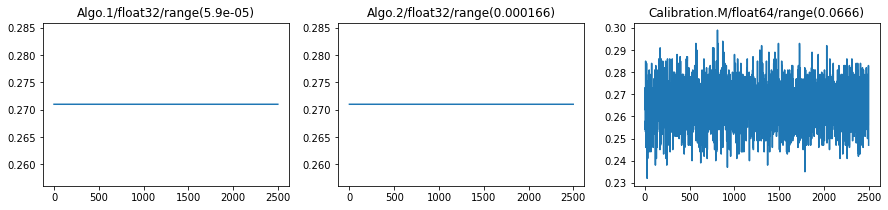

In [20]:
preci = 4
kms = km_RTX3090
plt.figure(figsize=(3*5,1*3))
plt.subplot(1,3,1)
plt.plot(range(2500), np.round(kms[:,0], preci-1))
plt.title("Algo.1/float32/range({})".format(round(max_sub_min((kms[:,0])),preci+2)))
plt.subplot(1,3,2)
plt.plot(range(2500), np.round(kms[:,1], preci-1))
plt.title("Algo.2/float32/range({})".format(round(max_sub_min((kms[:,1])),preci+2)))
plt.subplot(1,3,3)
plt.plot(range(2500), np.round(kms[:,2], preci-1))
plt.title("Calibration.M/float64/range({})".format(round(max_sub_min((kms[:,2])),preci)))
# plt.show()
# plt.savefig("./results/km_RTX3090.jpg")

Text(0.5, 1.0, 'Calibration.M/float64/range(0.0666)')

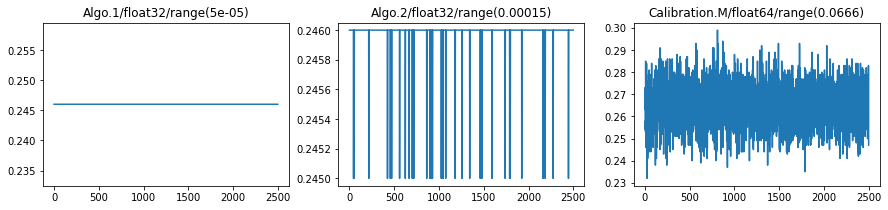

In [21]:
preci = 4
kms = km_RTXA4000
plt.figure(figsize=(3*5,1*3))
plt.subplot(1,3,1)
plt.plot(range(2500), np.round(kms[:,0], preci-1))
plt.title("Algo.1/float32/range({})".format(round(max_sub_min((kms[:,0])),preci+1)))
plt.subplot(1,3,2)
plt.plot(range(2500), np.round(kms[:,1], preci-1))
plt.title("Algo.2/float32/range({})".format(round(max_sub_min((kms[:,1])),preci+1)))
plt.subplot(1,3,3)
plt.plot(range(2500), np.round(kms[:,2], preci-1))
plt.title("Calibration.M/float64/range({})".format(round(max_sub_min((kms[:,2])),preci)))
# plt.show()
# plt.savefig("./results/km-RTXA4000.jpg")

Text(0.5, 1.0, 'Calibration.M/float64/range(0.0666)')

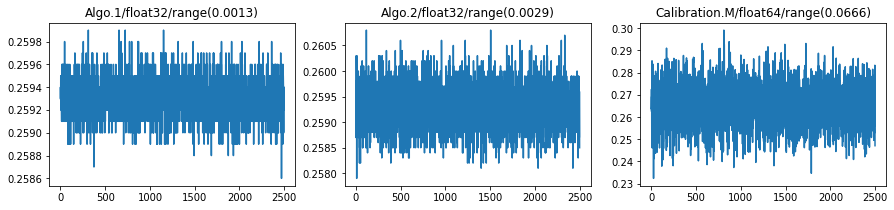

In [22]:
preci = 4
kms = km_RTX2080
plt.figure(figsize=(3*5,1*3))
plt.subplot(1,3,1)
plt.plot(range(2500), np.round(kms[:,0], preci))
plt.title("Algo.1/float32/range({})".format(round(max_sub_min((kms[:,0])),preci)))
plt.subplot(1,3,2)
plt.plot(range(2500), np.round(kms[:,1], preci))
plt.title("Algo.2/float32/range({})".format(round(max_sub_min((kms[:,1])),preci)))
plt.subplot(1,3,3)
plt.plot(range(2500), np.round(kms[:,2], preci))
plt.title("Calibration.M/float64/range({})".format(round(max_sub_min((kms[:,2])),preci)))
# plt.show()
# plt.savefig("./results/km_RTX2080.jpg")

## Recv

In [23]:
dtype=torch.float64
device="cuda"
N = 128*128

In [24]:
W = dct_matrix(N,dtype=dtype,device=device)
WT = torch.inverse(W)

In [54]:
recv_names=["mt_recv_RTX2080","mt_recv_RTXA4000","mt_recv_RTX3090"]
recv_A_names=["A_recv_algo1","A_recv_algo2","A_recv_cm"]

### GPSR Recv

In [55]:
tau=.35
stopCri = 4
tolAs = [1e-3,1e-3,1e15]
tolD = 0.0001

In [27]:
recv_res = []
for recv_name in recv_names:
    f = h5py.File("{}/{}.h5".format(root,recv_name))
    y = torch.tensor(np.array(f["y_u"]),device=device,dtype=dtype)
    recv_res_n=[]
    for j in range(len(recv_A_names)):
        A_name = recv_A_names[j]
        tolA = tolAs[j]
        A = torch.tensor(np.array(f[A_name]),device=device,dtype=dtype)
    
        AW = A @ W
        hR = lambda x: AW @ x
        AT = lambda x: AW.T @ x

        [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
            GPSR_Basic(
              y,hR,tau,device,dtype,
                Debias=0,
                AT=AT,
                Initialization=AT(y),
                StopCriterion=stopCri,
                ToleranceA=tolA,
                ToleranceD=tolD,
                Iters=100,
                Verbose=False
            )
        recv_img = (W @ theta)
        print("done")
        recv_res_n.append(recv_img)
    recv_res.append(recv_res_n)

done
done
done
done
done
done
done
done
done


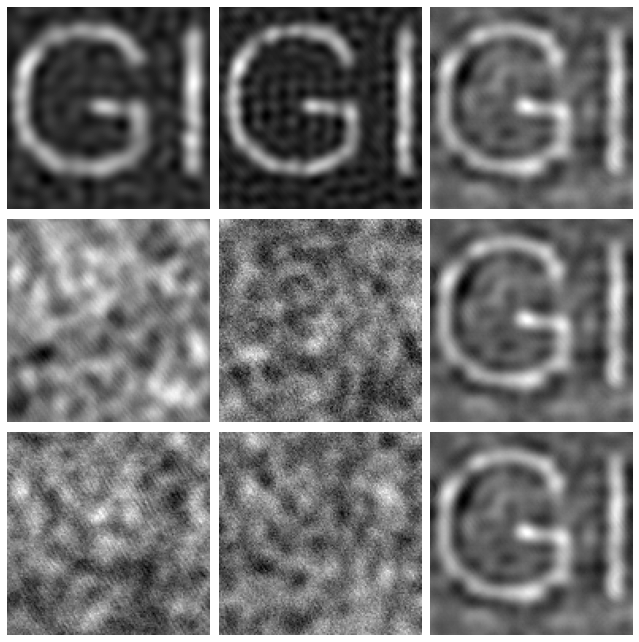

In [29]:
rows=len(recv_names)
columns=len(recv_A_names)
plt.figure(figsize=(columns*3,rows*3))
for i in range(rows):
    for j in range(columns):   
        plt.subplot(rows,columns,j+1+i*columns)
        recv_img = recv_res[i][j]
        plt.imshow(recv_img.cpu().numpy().reshape((128,128)),cmap="gray")
        plt.axis("off")
plt.tight_layout(pad=1)
# plt.show()
plt.savefig("{}/recv.jpg".format(root))

### OMP Recv

In [56]:
recv_res_omp = []
for recv_name in recv_names:
    f = h5py.File("{}/{}.h5".format(root,recv_name))
    y = torch.tensor(np.array(f["y_u"]),device=device,dtype=dtype)
    recv_res_n=[]
    for j in range(len(recv_A_names)):
        A_name = recv_A_names[j]
        A = torch.tensor(np.array(f[A_name]),device=device,dtype=dtype)
        AW = A @ W
        K=int(N*0.3)
        recv_img,_=cs_omp(y,AW,N,K,Psi=W, device=device, dtype=dtype, verbose=False)
        print("done")
        recv_res_n.append(recv_img)
    recv_res_omp.append(recv_res_n)

100%|██████████| 4915/4915 [01:25<00:00, 57.32it/s]


done


100%|██████████| 4915/4915 [03:07<00:00, 26.22it/s]


done


100%|██████████| 4915/4915 [11:43<00:00,  6.98it/s]


done


100%|██████████| 4915/4915 [00:06<00:00, 787.24it/s]


done


100%|██████████| 4915/4915 [00:06<00:00, 719.70it/s]


done


100%|██████████| 4915/4915 [12:28<00:00,  6.57it/s]


done


100%|██████████| 4915/4915 [00:06<00:00, 787.86it/s]


done


100%|██████████| 4915/4915 [00:07<00:00, 687.47it/s]


done


100%|██████████| 4915/4915 [10:56<00:00,  7.49it/s]


done


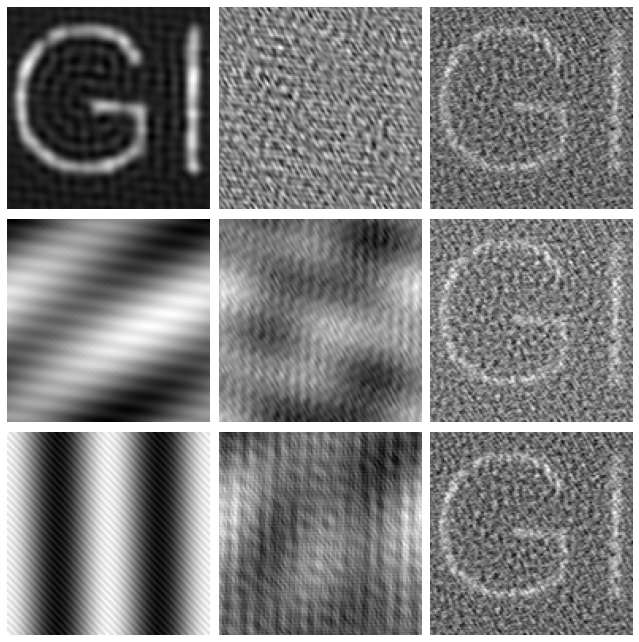

In [57]:
rows=len(recv_names)
columns=len(recv_A_names)
plt.figure(figsize=(columns*3,rows*3))
for i in range(rows):
    for j in range(columns):   
        plt.subplot(rows,columns,j+1+i*columns)
        recv_img = recv_res_omp[i][j]
        plt.imshow(recv_img.cpu().numpy().reshape((128,128)),cmap="gray")
        plt.axis("off")
plt.tight_layout(pad=1)
# plt.show()
plt.savefig("{}/recv_omp.jpg".format(root))

In [ ]:
tau=.35
stopCri = 4
tolA = 1e-3
tolD = 0.0001

f = h5py.File("{}/mt_recv_RTX3090.h5".format(root))
y = torch.tensor(np.array(f["y_u"]),device=device,dtype=dtype)
A = torch.tensor(np.array(f["A_recv_algo1"]),device=device,dtype=dtype)
AW = A @ W
hR = lambda x: AW @ x
AT = lambda x: AW.T @ x

[theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
    GPSR_Basic(
      y,hR,tau,device,dtype,
        Debias=0,
        AT=AT,
        Initialization=AT(y),
        StopCriterion=stopCri,
        ToleranceA=tolA,
        ToleranceD=tolD,
        Iters=100,
        Verbose=True
    )
recv_img = (W @ theta)
print("done")

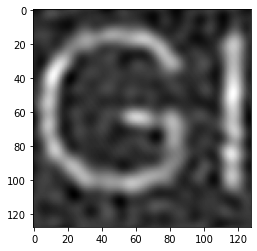

In [46]:
plt.imshow(recv_img.cpu().numpy().reshape((128,128)),cmap="gray")